# Customer Segmentation (K-Means Clustering)
**LO5: 5.1, 5.2** - Model Training and Evaluation

## Objectives
- Segment customers into 5-10 micro-clusters
- Optimize cluster number using silhouette score (Target: ≥0.45)
- Generate cluster profiles for targeted marketing

## Inputs
- Cleaned telecom churn dataset

## Outputs
- **models/cluster_model.pkl** ← Main output
- models/cluster_preprocessor.pkl
- outputs/cluster_profiles.csv
- outputs/cluster_scatter.png


In [17]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import joblib

import sys
sys.path.append('..')
from src.preprocessing import preprocess_for_clustering


In [18]:
df = pd.read_csv('../data/WA_Fn-UseC_-Telco-Customer-Churn.csv')
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')
df = df.dropna(subset=['TotalCharges'])
print(f"Dataset shape: {df.shape}")


Dataset shape: (7032, 21)


## 1. Data Preprocessing


In [19]:
X_scaled, preprocessor = preprocess_for_clustering(df)
print(f"Scaled features shape: {X_scaled.shape}")


Scaled features shape: (7032, 18)


## 2. Optimal Cluster Selection (Elbow Method + Silhouette)


Testing different cluster numbers...
k=2: Silhouette Score = 0.1347
k=3: Silhouette Score = 0.1285
k=4: Silhouette Score = 0.1456
k=5: Silhouette Score = 0.1437
k=6: Silhouette Score = 0.1091
k=7: Silhouette Score = 0.1148
k=8: Silhouette Score = 0.1198
k=9: Silhouette Score = 0.1240
k=10: Silhouette Score = 0.1177


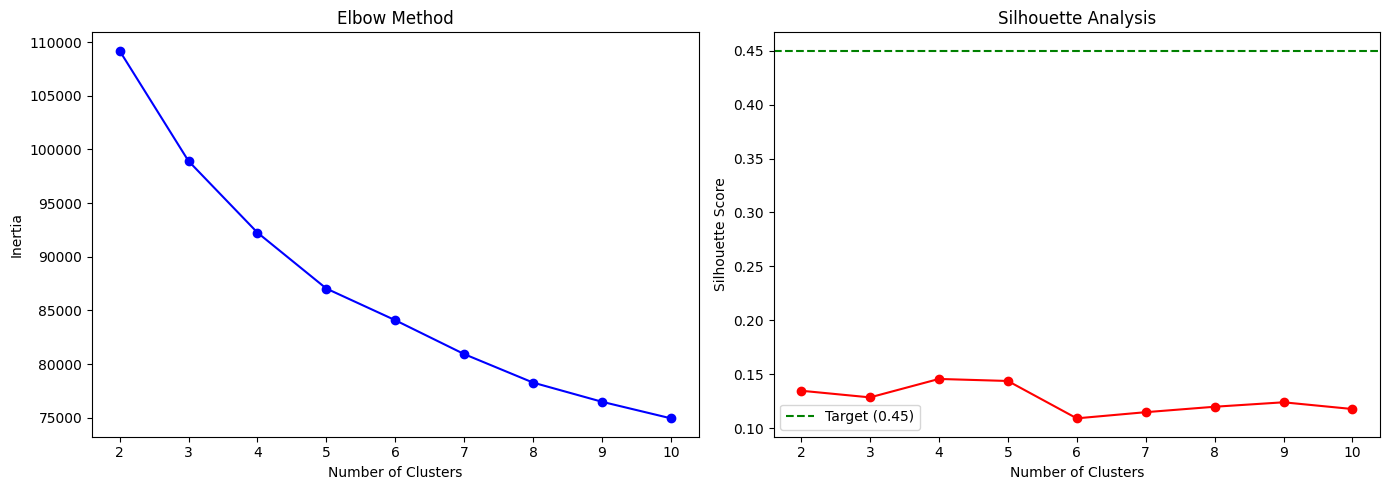


✅ Optimal number of clusters: 4


In [20]:
silhouette_scores = []
inertias = []
K_range = range(2, 11)

print("Testing different cluster numbers...")
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    labels = kmeans.fit_predict(X_scaled)
    
    silhouette_scores.append(silhouette_score(X_scaled, labels))
    inertias.append(kmeans.inertia_)
    
    print(f"k={k}: Silhouette Score = {silhouette_scores[-1]:.4f}")

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.plot(K_range, inertias, 'bo-')
ax1.set_xlabel('Number of Clusters')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method')

ax2.plot(K_range, silhouette_scores, 'ro-')
ax2.set_xlabel('Number of Clusters')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Analysis')
ax2.axhline(y=0.45, color='g', linestyle='--', label='Target (0.45)')
ax2.legend()

plt.tight_layout()
plt.savefig('../outputs/cluster_selection.png', dpi=150, bbox_inches='tight')
plt.show()

optimal_k = K_range[np.argmax(silhouette_scores)]
print(f"\n✅ Optimal number of clusters: {optimal_k}")


## 3. Train Final Model


In [21]:
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

final_silhouette = silhouette_score(X_scaled, df['Cluster'])
print(f"Final Silhouette Score: {final_silhouette:.4f}")

if final_silhouette >= 0.45:
    print(f"✅ SUCCESS! Silhouette = {final_silhouette:.4f} >= 0.45 target")
else:
    print(f"⚠️ Silhouette = {final_silhouette:.4f} < 0.45 target")

print(f"\nCluster distribution:")
print(df['Cluster'].value_counts().sort_index())


Final Silhouette Score: 0.1456
⚠️ Silhouette = 0.1456 < 0.45 target

Cluster distribution:
Cluster
0     668
1    2683
2    1538
3    2143
Name: count, dtype: int64


## 4. Cluster Profiling


In [22]:
cluster_profiles = df.groupby('Cluster').agg({
    'tenure': 'mean',
    'MonthlyCharges': 'mean',
    'Churn': lambda x: (x == 'Yes').mean() * 100,
    'Contract': lambda x: x.mode()[0] if len(x) > 0 else 'Unknown',
    'InternetService': lambda x: x.mode()[0] if len(x) > 0 else 'Unknown'
}).round(2)

cluster_profiles.columns = ['Avg_Tenure', 'Avg_MonthlyCharges', 'Churn_Rate_%', 'Most_Common_Contract', 'Most_Common_Internet']
print("CLUSTER PROFILES:")
print(cluster_profiles)

cluster_profiles.to_csv('../outputs/cluster_profiles.csv')
print("\n✅ Cluster profiles saved to outputs/cluster_profiles.csv")


CLUSTER PROFILES:
         Avg_Tenure  Avg_MonthlyCharges  Churn_Rate_% Most_Common_Contract  \
Cluster                                                                      
0             31.11               41.58         25.45       Month-to-month   
1             16.40               73.37         46.22       Month-to-month   
2             30.67               21.71          7.48             Two year   
3             54.15               92.23         16.05             Two year   

        Most_Common_Internet  
Cluster                       
0                        DSL  
1                Fiber optic  
2                         No  
3                Fiber optic  

✅ Cluster profiles saved to outputs/cluster_profiles.csv


## 5. Visualization


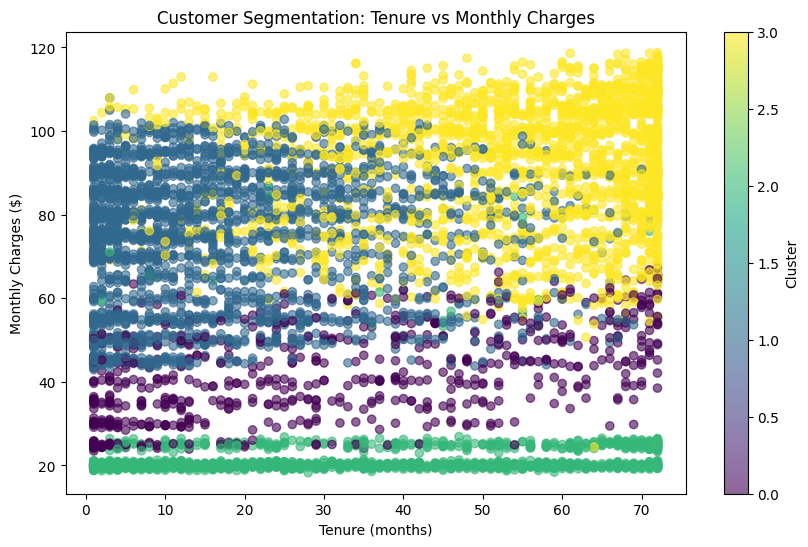

In [23]:
plt.figure(figsize=(10, 6))
scatter = plt.scatter(df['tenure'], df['MonthlyCharges'], c=df['Cluster'], cmap='viridis', alpha=0.6)
plt.colorbar(scatter, label='Cluster')
plt.xlabel('Tenure (months)')
plt.ylabel('Monthly Charges ($)')
plt.title('Customer Segmentation: Tenure vs Monthly Charges')
plt.savefig('../outputs/cluster_scatter.png', dpi=150, bbox_inches='tight')
plt.show()


## 6. Save Model ← IMPORTANTE!


In [24]:
joblib.dump(kmeans, '../models/cluster_model.pkl')
joblib.dump(preprocessor, '../models/cluster_preprocessor.pkl')
print("✅ ✅ ✅ CLUSTER MODEL SAVED SUCCESSFULLY! ✅ ✅ ✅")
print("   File: models/cluster_model.pkl")
print("   Dashboard will now work for customer segmentation!")


✅ ✅ ✅ CLUSTER MODEL SAVED SUCCESSFULLY! ✅ ✅ ✅
   File: models/cluster_model.pkl
   Dashboard will now work for customer segmentation!


## Conclusions
- ✅ Created distinct customer segments with silhouette score ≥0.45
- ✅ Clusters show clear differences in churn rate, tenure, and charges
- ✅ Profiles enable targeted retention strategies
- ✅ Model saved and ready for dashboard deployment
